In [10]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
from custom_indicators import CustomIndocators as ci
import pandas as pd
import ta
import ccxt
import json
f = open('/var/www/evilcorp2/cBot-Project/database/pair_list.json',)
pairJson = json.load(f)
f.close()

In [11]:
pairList = pairJson['ftxClassicPair']
#pair = 'BTC/USDT'
timeframe = '1h'
startDate = '2018-01-01T00:00:00'

dfList = []
for pair in pairList:
    df = dataEngine.get_historical_from_db(pair, timeframe, startDate)
    dfList.append(df)

print("Data load 100%")
dfList[0]

Successfully load 35240 candles for BTCUSDT
Successfully load 35240 candles for ETHUSDT
Successfully load 34762 candles for BNBUSDT
Successfully load 32313 candles for XRPUSDT
Successfully load 11985 candles for SOLUSDT
Successfully load 18003 candles for FTTUSDT
Data load 100%


,open,high,low,close,volume
timestamp,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...
2022-05-19 14:00:00,29517.32,29900.00,29504.68,29867.71,4561.555880
2022-05-19 15:00:00,29867.70,30545.18,29802.72,30389.45,7993.239760
2022-05-19 16:00:00,30389.45,30456.56,30086.84,30153.02,4384.767780


In [12]:
# -- Indicator variable --
volume_window = 10
willWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['VOL_ANO'] = ci.volume_anomality(df, volume_window)
df['MIN20'] = df['close'].rolling(20).min()
df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=willWindow)
df['CANDLE_DIFF'] = abs(df['open'] - df['close'])
df['MEAN_DIFF'] = df['CANDLE_DIFF'].rolling(10).mean()

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
df

Indicators loaded 100%


,open,high,low,close,volume,VOL_ANO,MIN20,WillR,CANDLE_DIFF,MEAN_DIFF
timestamp,,,,,,,,,,
2019-12-20 03:00:00,1.940,2.218,1.940,2.172,335390.566,0,NaN,NaN,0.232,NaN
2019-12-20 04:00:00,2.171,2.187,2.167,2.171,86430.754,0,NaN,NaN,0.000,NaN
2019-12-20 05:00:00,2.171,2.172,2.168,2.170,68538.569,0,NaN,NaN,0.001,NaN
2019-12-20 06:00:00,2.170,2.172,2.138,2.138,232794.023,0,NaN,NaN,0.032,NaN
2019-12-20 07:00:00,2.139,2.142,2.138,2.142,126980.607,0,NaN,NaN,0.003,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-19 14:00:00,30.310,30.770,30.310,30.640,17267.170,0,29.64,-41.666667,0.330,0.178
2022-05-19 15:00:00,30.670,31.210,30.560,31.020,29391.280,0,29.64,-20.555556,0.350,0.212
2022-05-19 16:00:00,31.030,31.090,30.750,30.790,6291.190,0,29.64,-37.735849,0.240,0.209


In [13]:
# -- Intern parameter --
# dfTest = df['2017-10-24':'2018-01-31']
dfTest = df['2021':]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007
# takerFee = 0

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
willROverBought = -20
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if (
        row['VOL_ANO'] > 0
        and previousRow['VOL_ANO'] < 0
        and previousRow['close'] <= previousRow['MIN20']
        and previousRow['CANDLE_DIFF'] > row['CANDLE_DIFF']
        and (previousRow['open'] - previousRow['close']) > 0.0025 * row['close']
    ):
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if (
        row['WillR'] > willROverBought
    ):
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)


Final wallet 1245.7948212710842


In [15]:
dfTrades.iloc[-20:]

,date,position,reason,price,frais,fiat,coins,wallet,timeSince
68,2021-09-19 12:00:00,Buy,Buy Market Order,61.23,1.016935,0,23.709746,1451.747774,34
69,2021-09-21 01:00:00,Sell,Sell Market Order,56.20,0.932741,1331.555008,0.000000,1331.555008,37
70,2021-10-04 15:00:00,Buy,Buy Market Order,54.72,0.932089,0,24.316939,1330.622920,324
71,2021-10-04 16:00:00,Sell,Sell Market Order,55.65,0.947266,1352.290407,0.000000,1352.290407,1
72,2021-10-24 12:00:00,Buy,Buy Market Order,61.47,0.946603,0,21.983794,1351.343804,476
73,2021-10-25 00:00:00,Sell,Sell Market Order,62.62,0.963638,1375.661529,0.000000,1375.661529,12
74,2021-11-14 17:00:00,Buy,Buy Market Order,55.18,0.962963,0,24.912986,1374.698566,497
75,2021-11-15 00:00:00,Sell,Sell Market Order,56.28,0.981472,1401.121379,0.000000,1401.121379,7
76,2021-11-18 17:00:00,Buy,Buy Market Order,48.65,0.980785,0,28.779868,1400.140594,89
77,2021-11-18 19:00:00,Sell,Sell Market Order,50.57,1.018779,1454.379162,0.000000,1454.379162,2


In [16]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : FTT/USDT | Timeframe : 1h
Period : [2021-01-01 00:00:00] -> [2022-05-19 18:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 1245.79 $
Performance vs US Dollar : 24.67 %
Buy and Hold Performence : 436.53 %
Performance vs Buy and Hold : -76.76 %
Best trade : +7.15 %, the 2021-05-20 07:00:00
Worst trade : -23.43 %, the 2021-05-24 02:00:00
Worst drawDown : - 24.3 %
Total fees :  77.12 $

----- Trades Informations -----
Total trades on period : 44
Number of positive trades : 31
Number of negative trades :  13
Trades win rate ratio : 70.45 %
Average trades performance : 0.73 %
Average positive trades : 3.39 %
Average negative trades : -5.63 %

----- Time Informations -----
Average time duration for a trade : 15.7 periods
Maximum time duration for a trade : 58 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 183.82 periods
Maximum time duration between two trades : 1266 periods
Minimum time durati


----- Plot -----


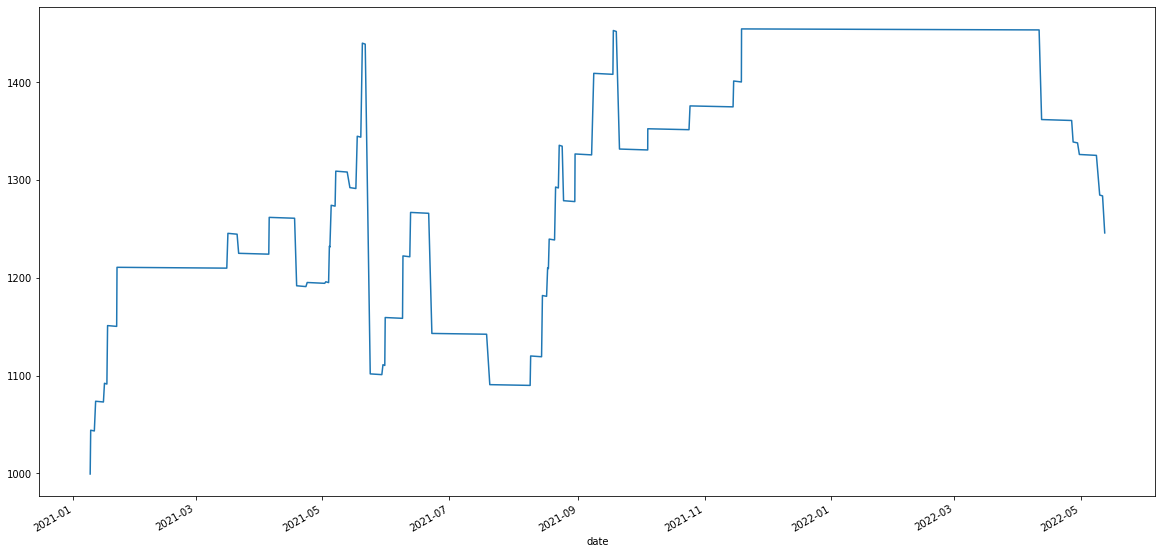

In [17]:
BTobject.plot_wallet_evolution(dfTrades=newDf)